In [20]:
# import necessary libraries
import csv
import eikon as ek
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime, timedelta
from functools import reduce

### [STEP 1] DATA GATHERING
Call Eikon Data API to get latest COVID-19 statistic

In [24]:
# first, get data of covid cases from Eikon
ek.set_app_key('#### PUT YOUR VALID APP KEY HERE ####')

# get RICs list from csv
case_to_get = {'total_case': 'NCOV19 Tot Cases RTR',
               'new_case': 'NCOV19 New Cases RTR',
               'death': 'NCOV19 Deaths RTR'}

fields = ['DSPLY_NMLL',  # Display Name
          'COUNTRY',    # Country code
          'CF_DATE',  # Announcement Date
          # 'ECON_ACT', # Actual value
          'ECON_PRIOR'     # Prior value # let's use data of the day before to get the complete one
          ]

rics = []

with open("CoronavirusRICs.csv", "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for lines in csv_reader:
        # get only some cases and RICs with valid country code
        if any(case_to_get[case] in lines[1] for case in case_to_get) and lines[2] != '' and '   ' not in lines[2]:
            rics.append(lines[0])

# COVID-19 statistic RICs are now in rics list
print(f'number of RICs in rics list: {len(rics)}')

# get COVID-19 statistic from Eikon Data API
eikon_df, err = ek.get_data(rics, fields)

# check error
if err == None:
    display(eikon_df.head())
else:
    print(err)

number of RICs in rics list: 624


,Instrument,DSPLY_NMLL,COUNTRY,CF_DATE,ECON_PRIOR
0,ADCCOV=ECI,NCOV19 Tot Cases RTR,AND,2021-08-14,14924
1,ADDCOV=ECI,NCOV19 Deaths RTR,AND,2021-08-14,129
2,ADNCOV=ECI,NCOV19 New Cases RTR,AND,2021-08-14,16
3,AECCOV=ECI,NCOV19 Tot Cases RTR,ARE,2021-08-14,699381
4,AEDCOV=ECI,NCOV19 Deaths RTR,ARE,2021-08-14,1994


## [STEP 2] COVID-19 DATA PREPARATION
If there's error, do the data preparation - format the dataframe to be ready for the visuallization

In [25]:
# Rename dataframe column names
eikon_df.rename(columns={'DSPLY_NMLL': 'display_name',
                         'COUNTRY': 'iso_a3',
                         'CF_DATE': 'announcement_date',
                         'ECON_PRIOR': 'value'
                         }, inplace=True)

# as select prior value, so let's update announcement date to the day before
eikon_df['announcement_date'] = eikon_df['announcement_date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') - timedelta(days=1))

# check column names and updated date
eikon_df.head()

,Instrument,display_name,iso_a3,announcement_date,value
0,ADCCOV=ECI,NCOV19 Tot Cases RTR,AND,2021-08-13,14924
1,ADDCOV=ECI,NCOV19 Deaths RTR,AND,2021-08-13,129
2,ADNCOV=ECI,NCOV19 New Cases RTR,AND,2021-08-13,16
3,AECCOV=ECI,NCOV19 Tot Cases RTR,ARE,2021-08-13,699381
4,AEDCOV=ECI,NCOV19 Deaths RTR,ARE,2021-08-13,1994


Then, rearrange the dataframe to be suitable for the visualization

In [71]:
def prep_eikon_data_each_case(case, df):
    res_df = df.loc[df['display_name'] == case_to_get[case]]
    res_df.rename(columns={'value': case}, inplace=True)
    res_df = res_df.drop(columns=['display_name', 'Instrument'])

    # wtf is the reason of this dtype? Int64(pandas) not support but int64(numpy) is supported [Numpy’s NaN to Pandas’ NA]
    # TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
    res_df[case] = pd.to_numeric(
        res_df[case], errors='coerce').fillna(0).astype('int64')
    return res_df


def prep_eikon_covid_data(df):
    df_to_be_merged = []
    for key in case_to_get:
        df_to_be_merged.append(prep_eikon_data_each_case(key, df))

    res_df = reduce(lambda left, right: pd.merge(left, right, on=[
                    'iso_a3', 'announcement_date']), df_to_be_merged)
    return res_df


eikon_covid_data_df = prep_eikon_covid_data(eikon_df)

# check formatted dataframe
eikon_covid_data_df.head()

,iso_a3,announcement_date,total_case,new_case,death
0,AND,2021-08-13,14924,16,129
1,ARE,2021-08-13,699381,1215,1994
2,AFG,2021-08-13,151770,0,7000
3,ATG,2021-08-13,1372,0,43
4,AIA,2021-08-13,127,0,0


## [STEP 3] GET GEOMETRY (country, population, geometry) DATA
Getting geo data from geopandas (geometry and population of each country code) and merge it with COVID-19 data

In [29]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# check the data
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [30]:
# merge geo and COVID-19 data together
merged_df = pd.merge(world, eikon_covid_data_df, on='iso_a3')
merged_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,announcement_date,total_case,new_case,death
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2021-08-13,39456,644,360
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",2021-08-13,1367,0,50
2,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",2021-08-13,1449851,2412,26698
3,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",2021-08-13,36774819,295097,620684
4,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",2021-08-13,679832,7510,7434


In [31]:
# calculate percentage of each case per population
def cal_case_pct_per_prop(df):
    for case in case_to_get:
        df['pct_'+case] = df[case]/df['pop_est']*100


cal_case_pct_per_prop(merged_df)

merged_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,announcement_date,total_case,new_case,death,pct_total_case,pct_new_case,pct_death
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2021-08-13,39456,644,360,4.284328,0.069929,0.039091
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",2021-08-13,1367,0,50,0.002534,0.000000,0.000093
2,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",2021-08-13,1449851,2412,26698,4.069908,0.006771,0.074945
3,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",2021-08-13,36774819,295097,620684,11.259006,0.090347,0.190029
4,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",2021-08-13,679832,7510,7434,3.663540,0.040471,0.040061


## [STEP 4] DATA VISUALIZATION
Plot world graph
Geopandas: making maps and plots https://geopandas.org/docs/user_guide/mapping.html

to see color map (cmap): https://matplotlib.org/2.0.2/users/colormaps.html

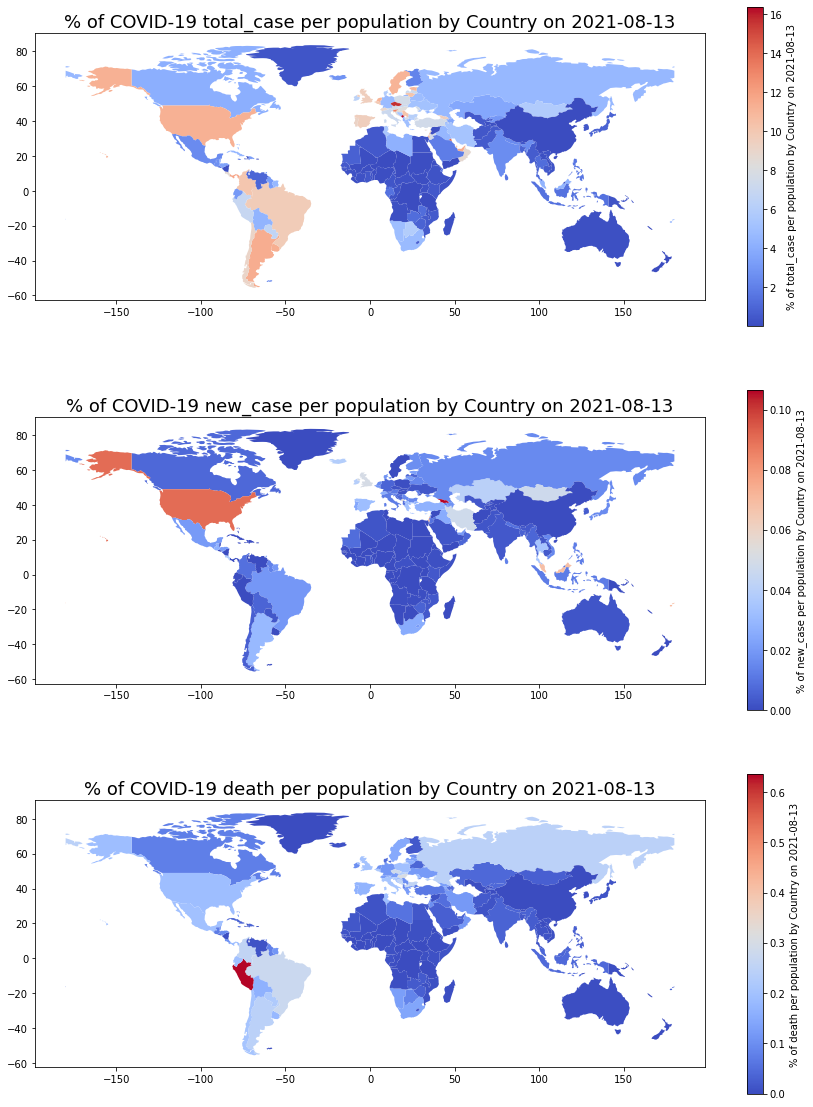

In [69]:
def plot_world_covid(df):
    axs = [ax1, ax2, ax3]
    count = 0
    for case in case_to_get:
        axs[count].set_title(f"% of COVID-19 {case} per population by Country on {df.announcement_date[0].date()}", fontsize=18)
        df.plot(column='pct_' + case, ax=axs[count], legend=True, cmap='coolwarm',
                legend_kwds={'label': f"% of {case} per population by Country on {df.announcement_date[0].date()}",
                             'orientation': "vertical"})
        count += 1

# plot graph
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(15, 20))

plot_world_covid(merged_df)

plt.show()